In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import multiprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, GRU
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM

In [2]:
import os
import seaborn as sns

In [3]:
#saved preprocessed data as stem.csv in previous notebook, lets import and build model on it.
data=pd.read_csv('stem.csv')

In [4]:
data=data.drop(columns=['Unnamed: 0'])

In [5]:
data=data.dropna()

In [6]:
data=data.reset_index()

In [7]:
data=data.drop(columns=['index'])

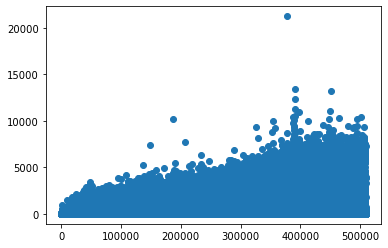

In [8]:
plt.scatter(data.index,data['up_votes'])

<AxesSubplot:ylabel='up_votes'>

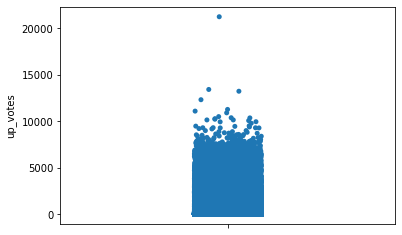

In [9]:
sns.stripplot(y=data['up_votes'])

In [10]:
data['up_votes'].describe()

count    509221.000000
mean        112.239421
std         541.702340
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max       21253.000000
Name: up_votes, dtype: float64

In [11]:
data.shape

(509221, 6)

In [12]:
data.loc[data['up_votes'] <= 5].shape, data.loc[data['up_votes'] >= 100].shape

((275842, 6), (50397, 6))

- considering above statistics, up_votes are categorized into 3 types: Low, high.

In [13]:
up_votes = data['up_votes']

vote = ["" for x in range(up_votes.size)]

for i in range(up_votes.size):
    if (up_votes[i] < 100):
        vote[i] = "low"
    else:
        vote[i] = "high"

data['demand'] = vote

In [14]:
df_trail=data.copy()

In [54]:
df_trail.tail(5)

,up_votes,title,over_18,cleaned_title,stemmed,stemd,demand
509216,5,Heil Trump : Donald Trump s alt-right white...,False,"['heil', 'trump', 'donald', 'trump', 's', 'alt...","['heil', 'trump', 'donald', 'trump', 's', 'alt...",heil trump donald trump s alt right white nati...,low
509217,1,There are people speculating that this could b...,False,"['people', 'speculating', 'madeleine', 'mccann']","['peopl', 'specul', 'madelein', 'mccann']",peopl specul madelein mccann,low
509218,1,Professor receives Arab Researchers Award,False,"['professor', 'receives', 'arab', 'researcher'...","['professor', 'receiv', 'arab', 'research', 'a...",professor receiv arab research award,low
509219,1,Nigel Farage attacks response to Trump ambassa...,False,"['nigel', 'farage', 'attack', 'response', 'tru...","['nigel', 'farag', 'attack', 'respons', 'trump...",nigel farag attack respons trump ambassador tweet,low
509220,1,Palestinian wielding knife shot dead in West B...,False,"['palestinian', 'wielding', 'knife', 'shot', '...","['palestinian', 'wield', 'knife', 'shot', 'dea...",palestinian wield knife shot dead west bank is...,low


In [17]:
vec=df_trail['stemd']
model = Word2Vec(sentences=vec, size=100, window=5, min_count=2, workers=multiprocessing.cpu_count())

In [18]:
model.wv.save_word2vec_format("embd.txt", binary=False)

In [19]:
embeddings_index = {}
f = open(os.path.join('','embd.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [20]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(df_trail['stemd'])
sequences = tokenizer.texts_to_sequences(df_trail['stemd'])
word_index = tokenizer.word_index
length = max([len(t.split()) for t in df_trail['title']])
title_pad = pad_sequences(sequences, maxlen = length)

In [21]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## LSTM

In [22]:
model = Sequential()
embedding_layer = Embedding(num_words,
                           100,
                           embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                           input_length=length,
                           trainable=True)
model.add(embedding_layer)
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(LSTM(units=100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [23]:
#demand
demand = df_trail[['demand']]
demand_=pd.get_dummies(demand, columns=['demand'])
demand=demand_.to_numpy()

In [25]:
X_train = title_pad[:-int(0.2*title_pad.shape[0])]
y_train = demand[:-int(0.2*title_pad.shape[0])]
X_test = title_pad[-int(0.2*title_pad.shape[0]):]
y_test = demand[-int(0.2*title_pad.shape[0]):]

In [26]:
X_train

array([[    0,     0,     0, ...,     3,    61,   255],
       [    0,     0,     0, ...,  1311,  7202,   581],
       [    0,     0,     0, ...,    68,    92,   102],
       ...,
       [    0,     0,     0, ...,    25, 13533, 11871],
       [    0,     0,     0, ...,   184,  7395,  4108],
       [    0,     0,     0, ...,   474,    67,  1181]], dtype=int32)

In [27]:
history=model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1, verbose=2)

Epoch 1/5
5729/5729 - 799s - loss: 0.2891 - accuracy: 0.9077 - val_loss: 0.3487 - val_accuracy: 0.8808
Epoch 2/5
5729/5729 - 783s - loss: 0.2697 - accuracy: 0.9087 - val_loss: 0.3479 - val_accuracy: 0.8808
Epoch 3/5
5729/5729 - 789s - loss: 0.2552 - accuracy: 0.9112 - val_loss: 0.3495 - val_accuracy: 0.8780
Epoch 4/5
5729/5729 - 798s - loss: 0.2402 - accuracy: 0.9160 - val_loss: 0.3826 - val_accuracy: 0.8768
Epoch 5/5
5729/5729 - 831s - loss: 0.2252 - accuracy: 0.9214 - val_loss: 0.3904 - val_accuracy: 0.8664


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 100)           7629100   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 64, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 7,709,702
Trainable params: 7,709,702
Non-trainable params: 0
_________________________________________________________________


In [29]:
y_pred=model.predict(X_test)

In [30]:
X_test

array([[    0,     0,     0, ...,   658,   168,    71],
       [    0,     0,     0, ...,   221,    19,    57],
       [    0,     0,     0, ...,   615,  2177, 11399],
       ...,
       [    0,     0,     0, ...,   256,   447,  1186],
       [    0,     0,     0, ...,  1726,   648,  1486],
       [    0,     0,     0, ...,    75,    17,    14]], dtype=int32)

In [31]:
#y_pred, y_test

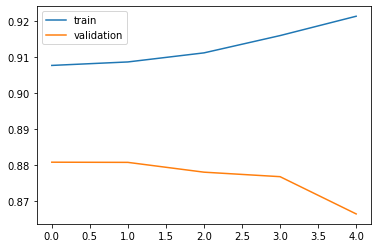

In [52]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()

In [32]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3183/3183 [==============================] - 28s 9ms/step - loss: 0.3812 - accuracy: 0.8729
Test set
  Loss: 0.381
  Accuracy: 0.873


# Results and Conclusion:

- Accuracy achieved is 0.873 with loss of 0.381.
- Further Developements:
 - Model can be developed by increasing number of epochs, as we can see above that accuracy is increasing.
 - Developing network architecture will gives best results.
 - Callbacks can be used to stop training after reaching certain threshold.
 - Creating pipelines and using modeling networks on our dataset. Moving forward we can create time series model by given timestamps. So then we can predict reach count of auidence.
- Further Results: 
 - Recommendations to users on event content.
 - Arrangements or adjustments of jobs(servers) can be made by predicting or estimating reach count.
 - From time series forecasting we can see trends and seasonality of events. For example in this dataset one event hosted in 2015 had more up_votes. The interesting observation: It was friday (weekend) and Evening hours. 

## Thank you
- Pradeep Medagiri, medagiri.pradeep@gmail.com
